SNPs matrix
========

Based on parSNP SNPs (and a parSNP tree with the outgroups removed)

<h6><a href="javascript:toggle()" target="_self">Toggle source code</a></h6>

In [2]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [3]:
%load_ext ipycache

In [70]:
# Other imports
import os
import pandas as pd
import numpy as np
from scipy import stats
import vcf
from Bio import SeqIO
from Bio import Phylo

In [4]:
pfiles = {x.replace('.vcf', '')
          for x in os.listdir('../pout/')
          if x.endswith('.vcf') and not x.endswith('.nonsyn.vcf')}

In [5]:
evol = set()
for l in open('../evolution_experiment.txt'):
    evol.add(l.strip())

In [6]:
t = Phylo.read('../tout/output_restricted/parsnp.tree', 'newick')
# Max distance to create better plots
mdist = max([t.distance(t.root, x) for x in t.get_terminals()])

In [7]:
# Where is K12? Remove it as it has no SNP (obviously)
for c, i in zip(t.get_terminals(), range(len(list(t.get_terminals())))):
    if c.name == 'genome.fasta.ref':
        t.prune(c)
        continue
    c.name = c.name.replace('.fasta', '')

In [8]:
# Which genomes do we want to use for the matrix?
# Only genomes in the tree
genomes = set([x.name for x in t.get_terminals()])

In [9]:
%%cache SNPs_matrix.pkl snps
pos = {}
for f in pfiles:
    if f not in genomes:
        continue
    if '%s.vcf'%f in os.listdir('../pout'):
        for r in vcf.Reader(open('../pout/%s.vcf'%f)):
            if not r.is_indel:
                pos[ (r.POS, str(r.ALT[0])) ] = pos.get((r.POS, str(r.ALT[0])),
                                                        {})
                pos[ (r.POS, str(r.ALT[0])) ][f] = 1
snps = pd.DataFrame(pos)

[Skipped the cell's code and loaded variables snps from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix.pkl'.]


In [10]:
# Missing values mean that SNP is not there
snps.replace(np.nan, 0, regex=True, inplace=True)

In [11]:
# Sort table by sum of SNPs presence
# More frequent SNPs will be on the right
idx = snps.T.sum(axis=1).order(ascending=False).index
snps_sorted = snps.T.ix[idx]

In [12]:
# Remove from the tree the tips that don't have a parsnp prediction
for c in t.get_terminals():
    if c.name not in snps_sorted.columns:
        t.prune(c)

In [13]:
# Sort against the tree
snps_sorted = snps_sorted[[x.name for x in t.get_terminals()]]

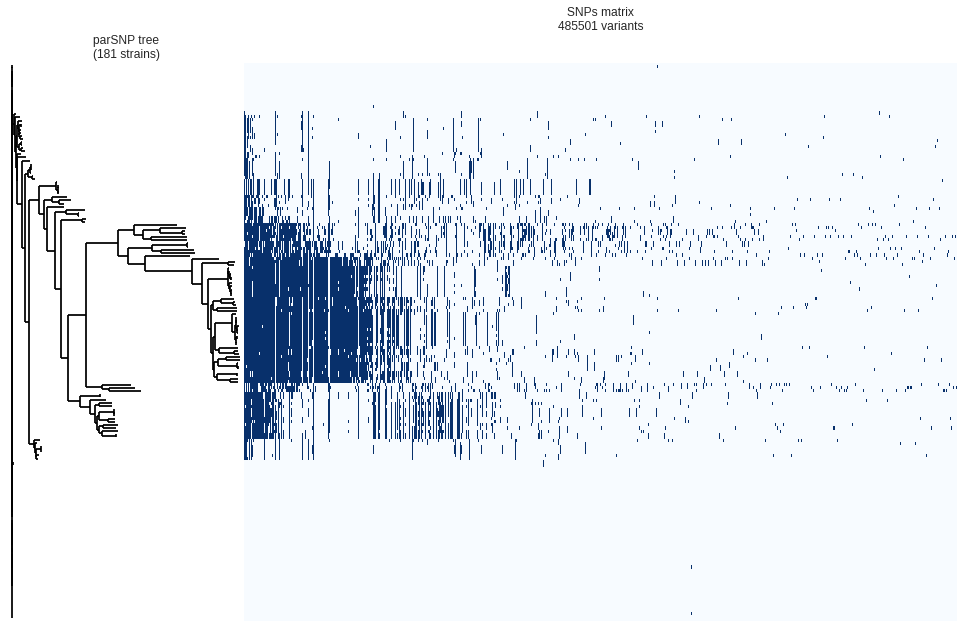

In [44]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.matshow(snps_sorted.T, cmap=plt.cm.Blues,
               vmin=0, vmax=1,
               aspect='auto',
               #interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('SNPs matrix\n%d variants'%snps.shape[1])

    Phylo.draw(t, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n(%d strains)'%snps.shape[0],), 
              )

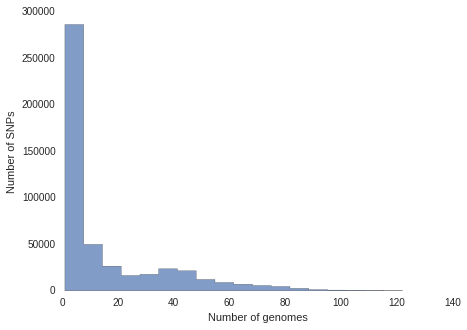

In [56]:
# Pangenome frequency plot
plt.figure(figsize=(7, 5))

plt.hist(snps.T.sum(axis=1), snps.T.shape[1]/10,
         histtype="stepfilled", alpha=.7)

plt.xlabel('Number of genomes')
plt.ylabel('Number of SNPs')

sns.despine(left=True,
            bottom=True)

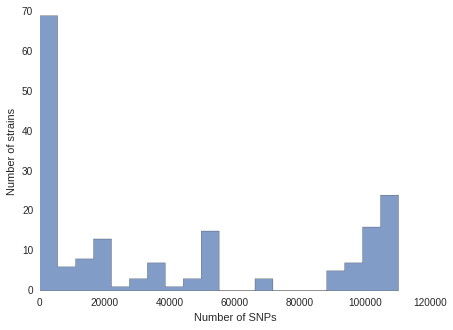

In [53]:
fig=plt.figure(figsize=(7, 5))
plt.hist(snps.T.sum(), bins=20,
        histtype="stepfilled", alpha=.7)
plt.xlabel('Number of SNPs')
plt.ylabel('Number of strains')
sns.despine(bottom=True,
            left=True)

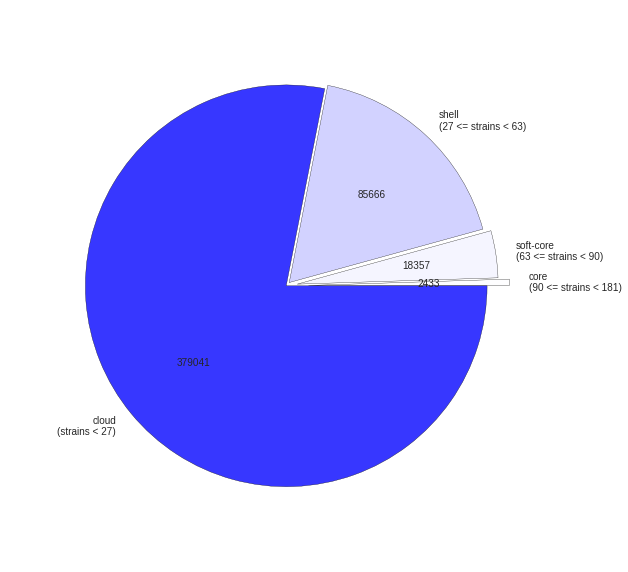

In [60]:
# Plot the panvariome pie chart
plt.figure(figsize=(10, 10))

core = snps_sorted[(snps_sorted.sum(axis=1) <= snps_sorted.shape[1]) &
                 (snps_sorted.sum(axis=1) >= snps_sorted.shape[1]*0.5)].shape[0]
softcore = snps_sorted[(snps_sorted.sum(axis=1) < snps_sorted.shape[1]*0.5) &
                 (snps_sorted.sum(axis=1) >= snps_sorted.shape[1]*0.35)].shape[0]
shell = snps_sorted[(snps_sorted.sum(axis=1) < snps_sorted.shape[1]*0.35) &
                 (snps_sorted.sum(axis=1) >= snps_sorted.shape[1]*0.15)].shape[0]
cloud = snps_sorted[snps_sorted.sum(axis=1) < snps_sorted.shape[1]*0.15].shape[0]

total = snps_sorted.shape[0]

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([core, softcore, shell, cloud],
      labels=['core\n(%d <= strains < %d)'%(snps_sorted.shape[1]*.5,
                                                 snps_sorted.shape[1]),
              'soft-core\n(%d <= strains < %d)'%(snps_sorted.shape[1]*.35,
                                                 snps_sorted.shape[1]*.5),
              'shell\n(%d <= strains < %d)'%(snps_sorted.shape[1]*.15,
                                             snps_sorted.shape[1]*.35),
              'cloud\n(strains < %d)'%(snps_sorted.shape[1]*.15)],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(0, 0, 1, float(x)/total) for x in (core, softcore, shell, cloud)],
      autopct=my_autopct)

Coding/noncoding ratios
---------------------------

In [15]:
s = SeqIO.read('../genome.gbk', 'genbank')
coding = [(int(f.location.start), int(f.location.end))
          for f in s.features
          if f.type == 'CDS' and
          'pseudo' not in f.qualifiers]

In [17]:
%%cache SNPs_matrix1.pkl cod non_cod dcoding
# What is the proportion of coding/non-coding?
cod = 0 
non_cod = 0

dcoding = {}

for x in range(1, len(s)+1):
    b = False
    for start, end in coding:
        if start <= x <= end:
            b = True
            break
    if b:
        cod += 1
        dcoding[x] = True
    else:
        non_cod += 1
        dcoding[x] = False

[Saved variables cod, dcoding, non_cod to file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix1.pkl'.]


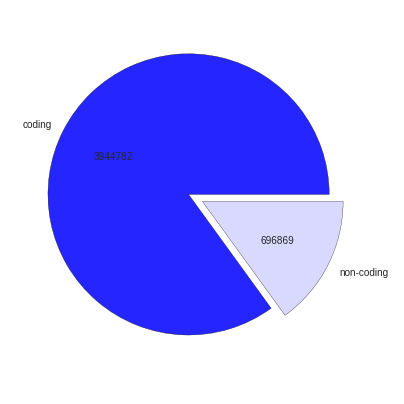

In [18]:
plt.figure(figsize=(7, 7))

total = len(s)

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([cod, non_cod], labels=['coding', 'non-coding'],
      explode=[0.1, 0], radius=0.9,
      colors=[(0, 0, 1, float(x)/total) for x in (cod, non_cod)],
      autopct=my_autopct)

In [42]:
%%cache SNPs_matrix2.pkl coding
coding = {}
for strain in snps.index:
    coding[strain] = [0, 0]
for snp in snps.columns:
    a = snps[snp] == 1
    for strain in a[a == True].index:
        if dcoding[snp[0]]:
            coding[strain][0] += 1
        else:
            coding[strain][1] += 1

[Saved variables coding to file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix2.pkl'.]


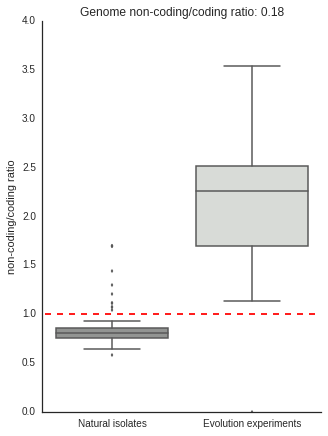

In [50]:
plt.figure(figsize=(5, 7))

sns.boxplot([[(coding[x][1]/float(non_cod))/(float(coding[x][0])/cod)
              for x in coding
              if x.split('_')[0] not in evol],
             [(coding[x][1]/float(non_cod))/(float(coding[x][0])/cod)
              for x in coding
              if x.split('_')[0] in evol]],
           names=['Natural isolates', 'Evolution experiments'],
           color=(sns.xkcd_rgb["grey"],
                  sns.xkcd_rgb["light grey"]))

plt.hlines(1, 0, 3.5, linestyles='dashed', colors=['r'])

plt.ylabel('non-coding/coding ratio')
plt.title('Genome non-coding/coding ratio: %.2f'%(float(non_cod)/cod))

sns.despine()

Conserved/variable genes
----------------------------

In [51]:
ls_bsr = pd.read_table('../lreference/bsr_matrix_values.txt')

In [52]:
ls_bsr.rename(columns={ls_bsr.columns[0]:'Gene'}, inplace=True)
ls_bsr.set_index('Gene', inplace=True)

In [61]:
ls_bsr.drop([x for x in ls_bsr.columns if x.split('_')[0] in evol],
            axis=1,
            inplace=True)

In [62]:
conservation = ls_bsr.sum(axis=1)

In [66]:
%%cache SNPs_matrix3.pkl pgenes
pgenes = {}
for f in [x for x in os.listdir('../pout/') if x.endswith('.nonsyn.vcf')]:
    if f.split('_')[0] in evol:
        continue
    pgenes[f.replace('.nonsyn.vcf', '')] = {}
    for r in vcf.Reader(open('../pout/%s'%f)):
        g = r.INFO['CDS']
        pgenes[f.replace('.nonsyn.vcf', '')][g] = pgenes[f.replace('.nonsyn.vcf', '')].get(g, 0)
        pgenes[f.replace('.nonsyn.vcf', '')][g] += 1

[Saved variables pgenes to file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix3.pkl'.]


In [67]:
pallgenes = set()
for f, v in pgenes.items():
    for g in v:
        pallgenes.add(g)

In [105]:
pvalues = []
pallvalues=[]
for g in pallgenes:
    varg = []
    for f, v in pgenes.items():
        if g in v:
            varg.append(v[g])
    pvalues.append( (np.median(varg), conservation.loc[g]) )
    pallvalues.append(varg)

In [101]:
conserved = max([x[1] for x in pvalues])*0.95
muts = 20

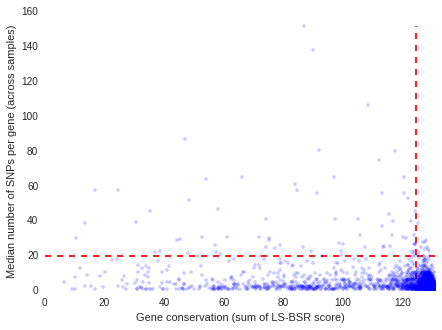

In [104]:
plt.figure(figsize=(7, 5))

plt.plot([x[1] for x in pvalues],
         [x[0] for x in pvalues],
         'b.',
         alpha=0.2)
plt.xlabel('Gene conservation (sum of LS-BSR score)')
plt.ylabel('Median number of SNPs per gene (across samples)')

plt.hlines(muts, 0, ls_bsr.shape[1], linestyles='dashed', colors=['r'])
plt.vlines(conserved, 0, max([x[0] for x in pvalues]), linestyles='dashed', colors=['r'])

plt.xlim(0, ls_bsr.shape[1])
sns.despine(left=True,
            bottom=True)

In [103]:
print('Genes with lower conservation have more non-synonymous mutations (Fisher extact test)')

print('Gene is conserved if it has LS-BSR score sum of %.2f (over %d strains)'%(conserved, ls_bsr.shape[1]))
print('Gene is considered to have many non-synonymous mutations when they are more than %d '%muts+
      'in the sample where it has the highest number of those mutations')
print('')

e1 = [1 for (s, c) in pvalues if c <= conserved and s > muts]
e2 = [1 for (s, c) in pvalues if c <= conserved and s <= muts]

e3 = [1 for (s, c) in pvalues if c > conserved and s > muts]
e4 = [1 for (s, c) in pvalues if c > conserved and s <= muts]

x, p = stats.fisher_exact( [[len(e1), len(e3)],
                     [len(e2), len(e4)]],
                   alternative='greater')
print('p-value: %.2e'%p)

Genes with lower conservation have more non-synonymous mutations (Fisher extact test)
Gene is conserved if it has LS-BSR score sum of 124.45 (over 131 strains)
Gene is considered to have many non-synonymous mutations when they are more than 20 in the sample where it has the highest number of those mutations

p-value: 4.11e-35
